# Reliability Diagram

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from os.path import join

from cal_methods import HistogramBinning, TemperatureScaling
from betacal import BetaCalibration
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

/root/autodl-tmp/miniconda3/envs/calibration/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
2023-04-25 20:15:13.310133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 20:15:13.447712: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 20:15:14.219384: W tensorflow/compiler/xla/stream_executor/platform/

In [2]:
# Imports to get "utility" package
import sys
from os import path
sys.path.append( path.dirname( path.dirname( path.abspath("utility") ) ) )
from utility.unpickle_probs import unpickle_probs
from utility.evaluation import get_bin_info, softmax

Script for plotting reliability diagrams.

## Load in the data

In [4]:
PATH = join('..', '..', 'logits')
files = (
        'probs_resnet110_c10_logits.p', 'probs_resnet110_c100_logits.p', 
        'probs_densenet40_c10_logits.p', 'probs_densenet40_c100_logits.p',
        'probs_resnet_wide32_c10_logits.p', 'probs_resnet_wide32_c100_logits.p',
        'probs_resnet50_birds_logits.p', 
        'probs_resnet110_SD_c10_logits.p', 'probs_resnet110_SD_c100_logits.p', 
        'probs_resnet152_SD_SVHN_logits.p',
        'probs_resnet152_imgnet_logits.p', 'probs_densenet161_imgnet_logits.p'
        )


In [3]:
PATH = join('/root/autodl-tmp/HugCode/custom/calibration/scripts', 'logits')
files = ('/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_clone-graphcodebert_c2_logits.p',
'/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_clone-plbart_c2_logits.p',
'/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_clone-codet5_c2_logits.p',
# '/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_clone-unixcoder_c2_logits.p',
'/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-graphcodebert_c2_logits.p',
'/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-plbart_c2_logits.p',
'/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-codet5_c2_logits.p',
'/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-unixcoder_c2_logits.p',
)

### Reliability diagrams as subgraph

In [4]:
# reliability diagram plotting for subplot case.
def rel_diagram_sub(accs, confs, ax, M = 10, name = "Reliability Diagram", xname = "", yname=""):

    acc_conf = np.column_stack([accs,confs])
    acc_conf.sort(axis=1)
    outputs = acc_conf[:, 0]
    gap = acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    # Plot gap first, so its below everything
    gap_plt = ax.bar(positions, gap, width = bin_size, edgecolor = "red", color = "red", alpha = 0.3, label="Gap", linewidth=2, zorder=2)

    # Next add error lines
    #for i in range(M):
        #plt.plot([i/M,1], [0, (M-i)/M], color = "red", alpha=0.5, zorder=1)

    #Bars with outputs
    output_plt = ax.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)

    # Line plot with center line.
    ax.set_aspect('equal')
    ax.plot([0,1], [0,1], linestyle = "--")
    ax.legend(handles = [gap_plt, output_plt])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(name, fontsize=24)
    ax.set_xlabel(xname, fontsize=22, color = "black")
    ax.set_ylabel(yname, fontsize=22, color = "black")

In [7]:
def get_pred_conf(y_probs, normalize = False):
    
    y_preds = np.argmax(y_probs, axis=1)  # Take maximum confidence as prediction
    
    if normalize:
        y_confs = np.max(y_probs, axis=1)/np.sum(y_probs, axis=1)
    else:
        y_confs = np.max(y_probs, axis=1)  # Take only maximum confidence
        
    return y_preds, y_confs

## Calibration methods for both 1-vs-rest and mutliclass approach

In [8]:
# TODO add into scripts
def cal_res(method, path, file, M = 15, name = "", approach = "single", m_kwargs = {}):
    
    bin_size = 1/M

    FILE_PATH = join(path, file)
    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_probs(FILE_PATH)

    y_probs_val = softmax(y_logits_val)  # Softmax logits
    y_probs_test = softmax(y_logits_test)
    
    if approach == "single":
        
        K = y_probs_test.shape[1]

        # Go through all the classes
        for k in range(K):
            # Prep class labels (1 fixed true class, 0 other classes)
            y_cal = np.array(y_val == k, dtype="int")[:, 0]

            # Train model
            model = method(**m_kwargs)
            model.fit(y_probs_val[:, k], y_cal) # Get only one column with probs for given class "k"

            y_probs_val[:, k] = model.predict(y_probs_val[:, k])  # Predict new values based on the fittting
            y_probs_test[:, k] = model.predict(y_probs_test[:, k])

            # Replace NaN with 0, as it should be close to zero  # TODO is it needed?
            idx_nan = np.where(np.isnan(y_probs_test))
            y_probs_test[idx_nan] = 0

            idx_nan = np.where(np.isnan(y_probs_val))
            y_probs_val[idx_nan] = 0
            
            y_preds_val, y_confs_val = get_pred_conf(y_probs_val, normalize = True)
            y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = True)
    
    else:
        model = method(**m_kwargs)
        model.fit(y_logits_val, y_val)

        y_probs_val = model.predict(y_logits_val) 
        y_probs_test = model.predict(y_logits_test)

        y_preds_val, y_confs_val = get_pred_conf(y_probs_val, normalize = False)
        y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = False)
    

    
    accs_val, confs_val, len_bins_val = get_bin_info(y_confs_val, y_preds_val, y_val, bin_size = bin_size)
    accs_test, confs_test, len_bins_test = get_bin_info(y_confs_test, y_preds_test, y_test, bin_size = bin_size)
    
    return (accs_test, confs_test, len_bins_test), (accs_val, confs_val, len_bins_val)
    

In [9]:
def get_uncalibrated_res(path, file, M = 15):
    
    bin_size = 1/M

    FILE_PATH = join(path, file)
    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_probs(FILE_PATH)

    y_probs_test = softmax(y_logits_test)
    y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = False)
    
    return get_bin_info(y_confs_test, y_preds_test, y_test, bin_size = bin_size)



In [10]:
import pickle

def gen_plots(files, plot_names =  [], M = 15, val_set = False):
    
    if val_set:  # Plot Reliability diagrams for validation set
        k = 1
    else:
        k = 0

    for i, file in enumerate(files):
        
        bin_info_uncal = get_uncalibrated_res(PATH, file, M)

        accs_confs = []

        accs_confs.append(cal_res(TemperatureScaling, PATH, file, M, "", "multi"))
        accs_confs.append(cal_res(HistogramBinning, PATH, file, M, "", "single", {'M':M}))
        accs_confs.append(cal_res(IsotonicRegression, PATH, file, M, "", "single", {'y_min':0, 'y_max':1}))
        accs_confs.append(cal_res(BetaCalibration, PATH, file, M, "", "single", {'parameters':"abm"}))
        
        with open(plot_names[i] + "_bin_info.p", "wb") as f:
            pickle.dump(accs_confs, f)

        plt.style.use('ggplot')
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22.5, 4), sharex='col', sharey='row')
        names = [" (Uncal)", " (Temp)", " (Histo)", " (Iso)", " (Beta)"]
        
        # Uncalibrated information
        rel_diagram_sub(bin_info_uncal[0], bin_info_uncal[1], ax[0] , M = M, name = "\n".join(plot_names[i].split()) + names[0], xname="Confidence")

        for j in range(4):
            rel_diagram_sub(accs_confs[j][k][0], accs_confs[j][k][1], ax[j+1] , M = M, name = "\n".join(plot_names[i].split()) + names[j+1], xname="Confidence")

        ax[0].set_ylabel("Accuracy", color = "black")
        
        for ax_temp in ax:    
            plt.setp(ax_temp.get_xticklabels(), rotation='horizontal', fontsize=18)
            plt.setp(ax_temp.get_yticklabels(), fontsize=18)

        plt.savefig("_".join(plot_names[i].split()) + ".pdf", format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.2)
        plt.show()

In [12]:
print(files)

('/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_clone-graphcodebert_c2_logits.p', '/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_clone-plbart_c2_logits.p', '/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_clone-codet5_c2_logits.p', '/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-graphcodebert_c2_logits.p', '/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-plbart_c2_logits.p', '/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-codet5_c2_logits.p', '/root/autodl-tmp/HugCode/custom/calibration/scripts/logits/probs_defect-unixcoder_c2_logits.p')


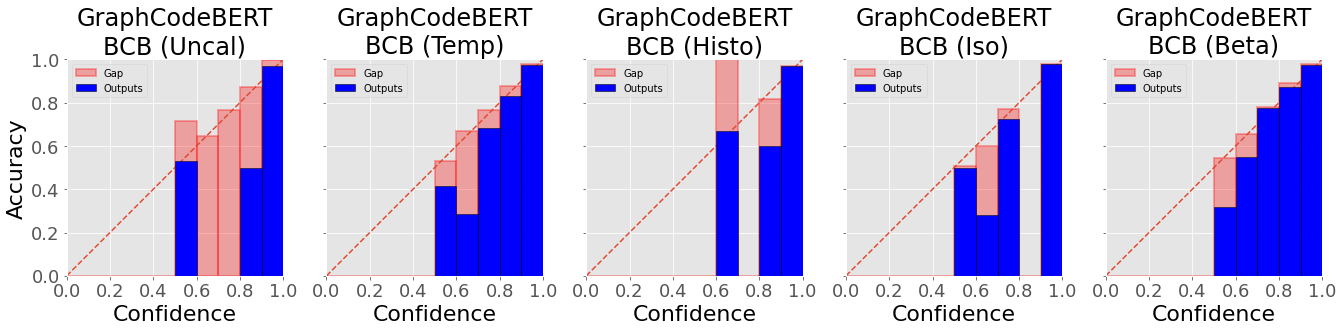

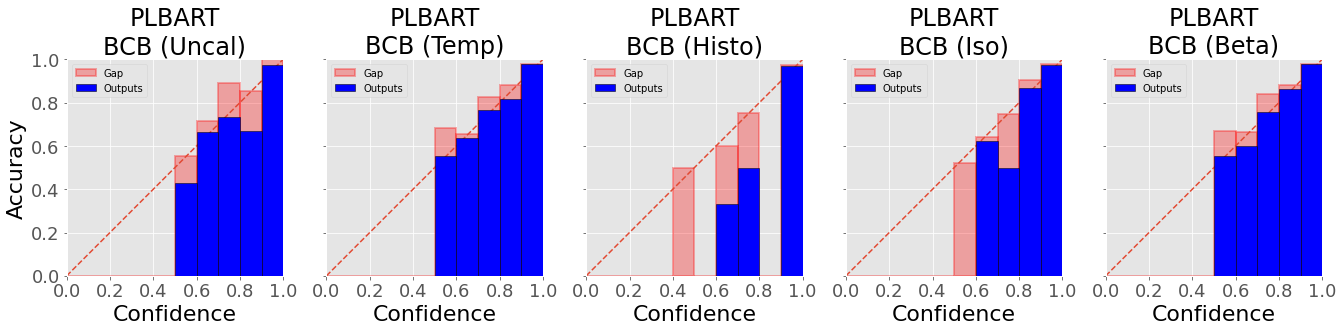

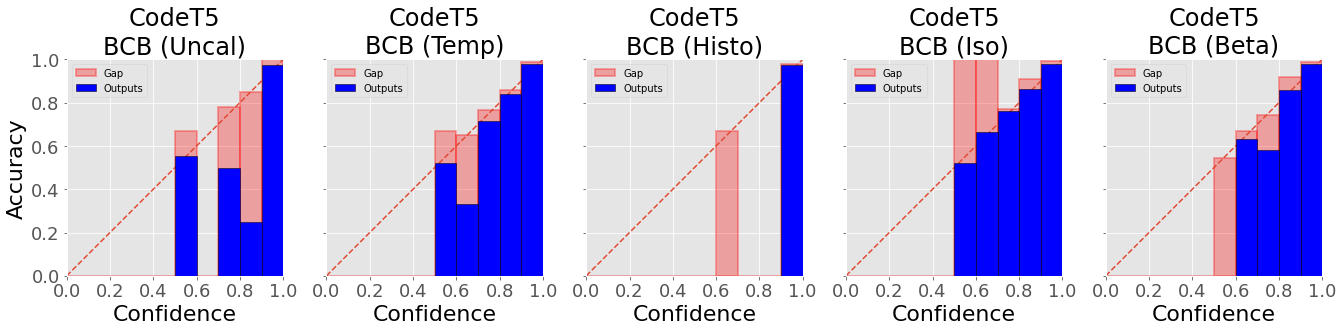

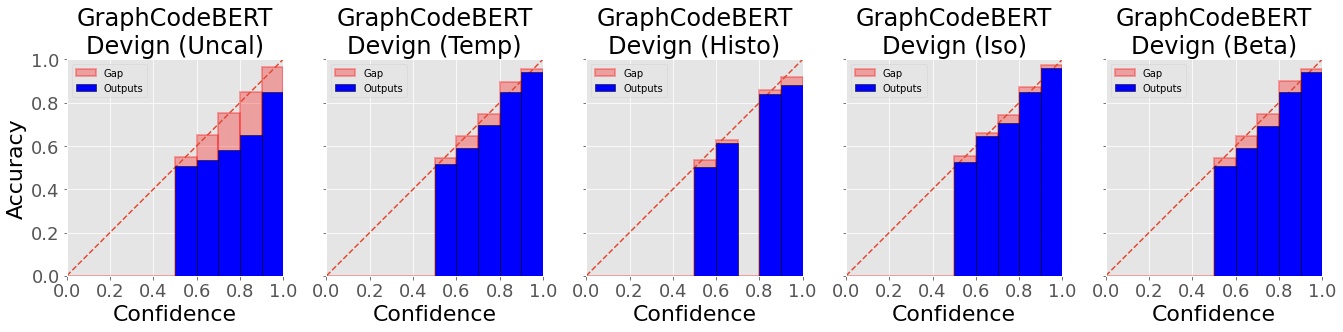

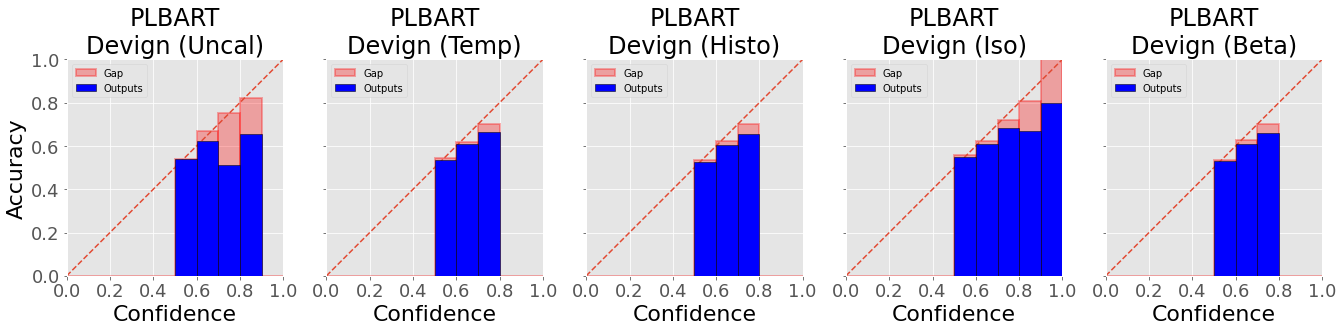

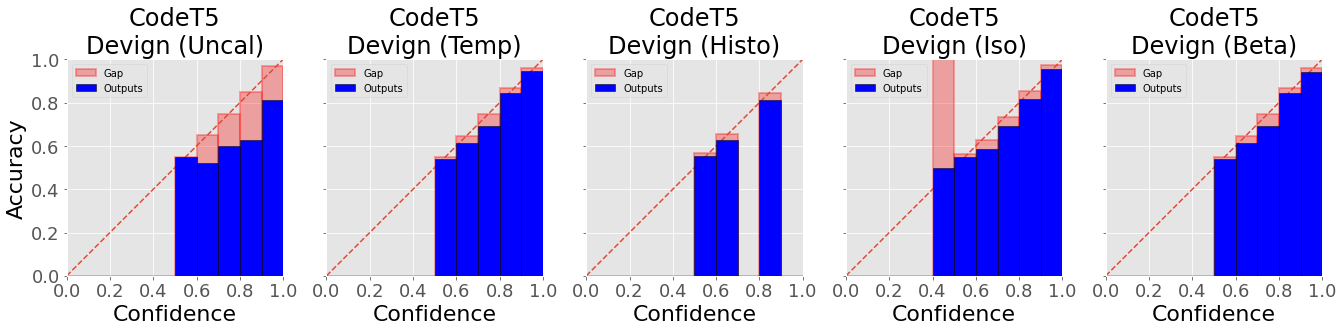

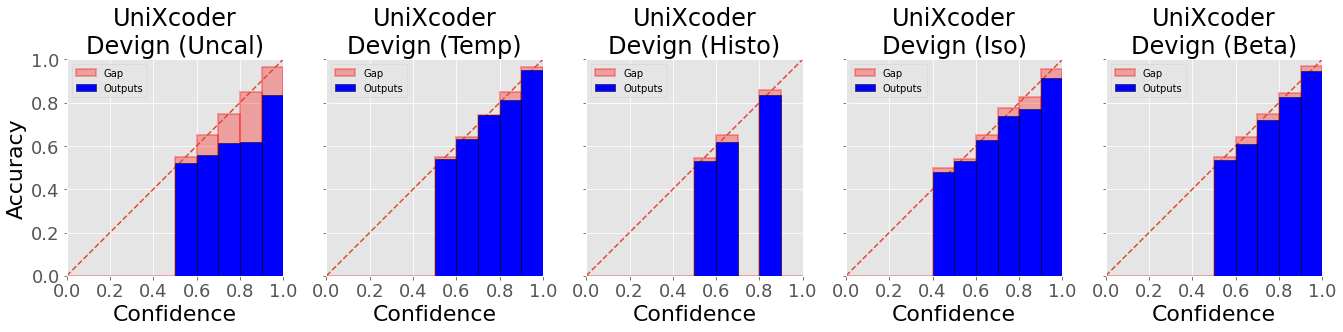

In [13]:
gen_plots(files, plot_names = ["GraphCodeBERT BCB", 
                                "PLBART BCB", "CodeT5 BCB", 
                               "GraphCodeBERT Devign", "PLBART Devign",
                               "CodeT5 Devign", "UniXcoder Devign",  
                               #"WideNet-32 Devign", "WideNet-32 CIFAR-100", 
                               #"ResNet-50 Birds", "ResNet-110(SD) CIFAR-10",
                               #"ResNet-110(SD) CIFAR-100",
                              #"ResNet-152(SD) SVHN",
                              #"ResNet-152 ImageNet", "DenseNet-161 ImageNet"
                               ], M = 10, val_set=False)

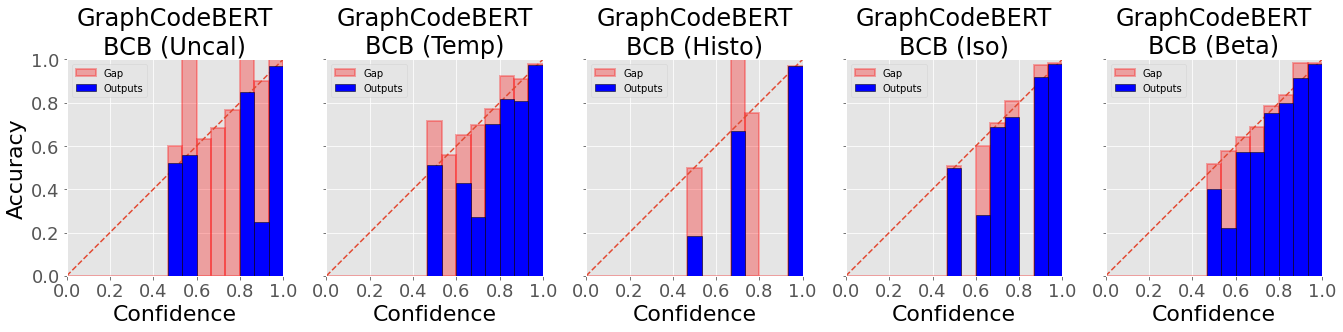

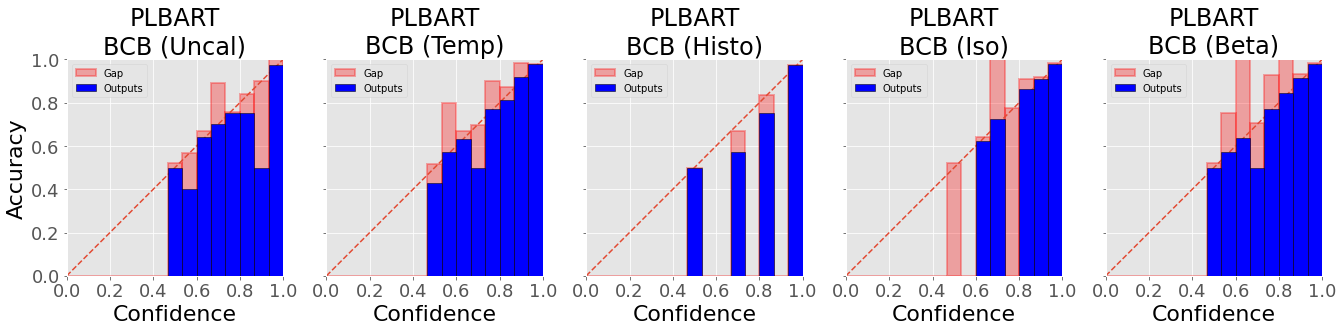

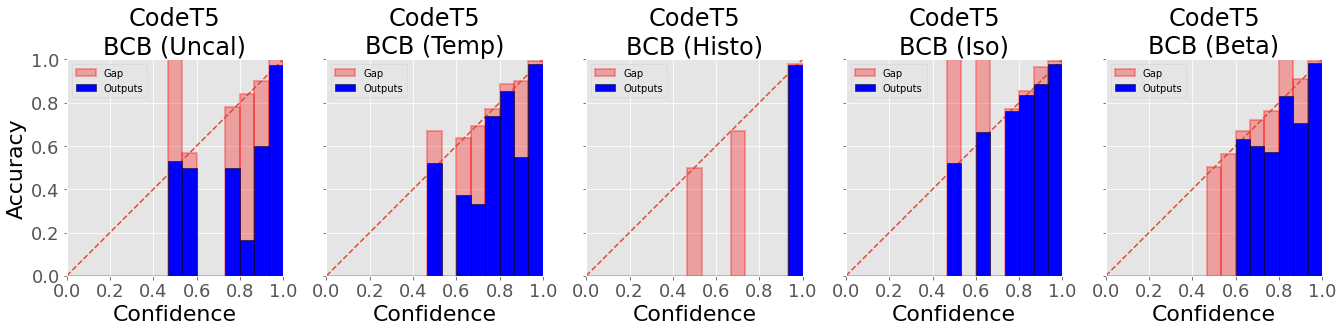

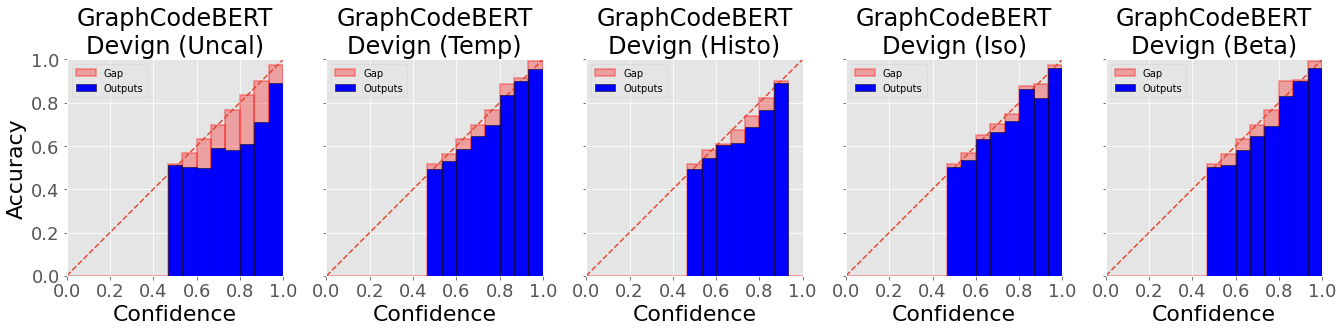

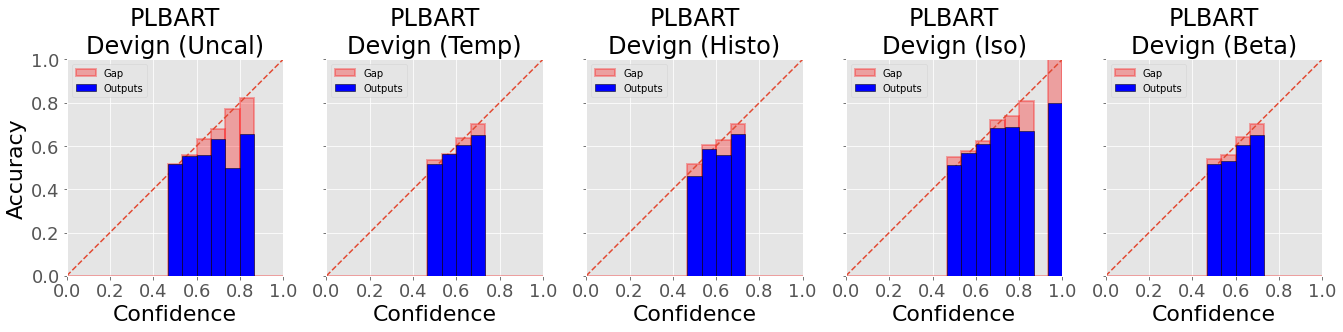

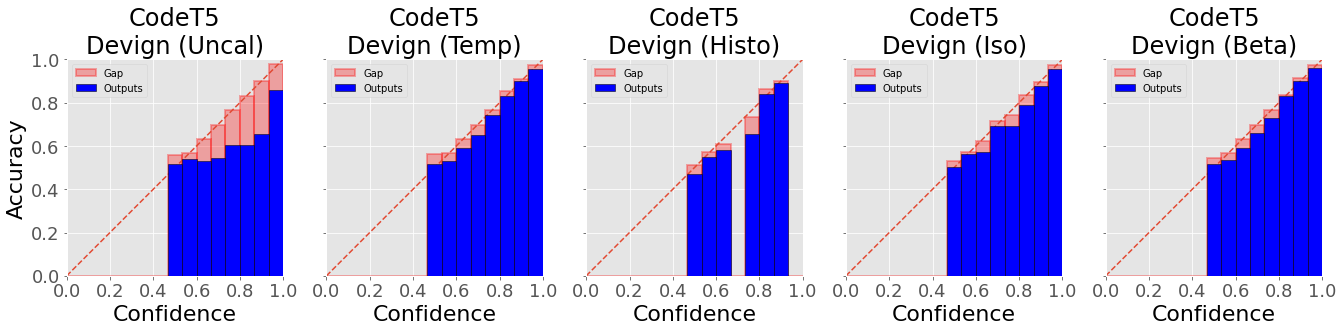

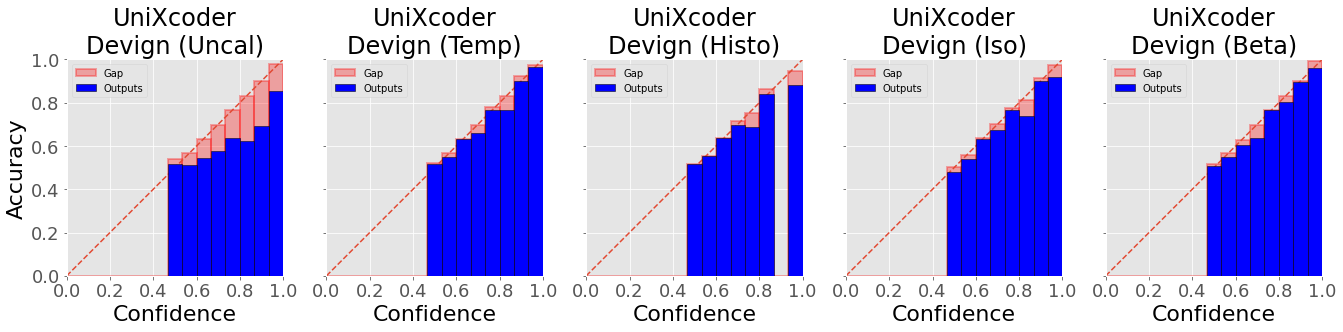

In [14]:
gen_plots(files, plot_names = ["GraphCodeBERT BCB", 
                                "PLBART BCB", "CodeT5 BCB", 
                               "GraphCodeBERT Devign", "PLBART Devign",
                               "CodeT5 Devign", "UniXcoder Devign",  
                               ], val_set = False)